In [1]:
%matplotlib inline

In [6]:
from empirical_disk_bulge.models.stability_timescale_functions import stability_timescale_vs_dvmax
from empirical_disk_bulge.models.stability_timescale_functions import stability_timescale_vs_vmax
from empirical_disk_bulge.models.stability_timescale_functions import stability_timescale

from umachine_pyio.load_mock import load_mock_from_binaries, value_added_mock

keys = list(('upid', 'obs_sfr', 'icl', 'mpeak', 'vmax_at_mpeak', 'dvmax_zscore', 
             'sfr', 'halo_id', 'mvir', 'rvir', 'vx', 'sm', 'vy', 'y', 'x',
             'z', 'vz', 'obs_sm'))
mock = value_added_mock(load_mock_from_binaries(np.arange(50), galprops=keys), 250.)

from scipy.special import erf
def _percentile_from_z_score(z_score):
    return 0.5*(1 + erf(z_score/np.sqrt(2)))
mock['dvmax_percentile'] = _percentile_from_z_score(mock['dvmax_zscore'])
mock['ssfr'] = np.log10(mock['sfr']/mock['sm'])

Total runtime = 0.19 seconds


In [29]:
vmax_control_points = np.array((100, 150, 250, 400))
dvmax_control_points = np.linspace(0, 1, 100)
vmax_arr = np.repeat(vmax_control_points, len(dvmax_control_points))
dvmax_arr = np.tile(dvmax_control_points, len(vmax_control_points))


from scipy.stats import norm
from scipy.stats import binned_statistic

def gaussian_kernel_selection(x, mu, sigma):
    prob = 1 - 2*np.abs(0.5 - norm.cdf(x, loc=mu, scale=sigma))
    return np.random.rand(len(x)) < prob

def estimate_ssfr_vs_percentile_relation(vmax, vmax0, percentile, sfr, 
                    dlog10vmax=0.1, percentile_bin_edges=np.linspace(0, 1, 101)):
    vmax_mask = gaussian_kernel_selection(np.log10(vmax), np.log10(vmax0), dlog10vmax)
    percentile_sample = percentile[vmax_mask]
    sfr_sample = sfr[vmax_mask]
    result, __, __ = binned_statistic(percentile_sample, sfr_sample, bins=percentile_bin_edges)
    return result, 0.5*(percentile_bin_edges[:-1] + percentile_bin_edges[1:])

vmax = mock['vmax_at_mpeak'].data
p = mock['dvmax_percentile'].data
ssfr = mock['ssfr']
ssfr_table_100, p_table = estimate_ssfr_vs_percentile_relation(vmax, 100, p, ssfr)
ssfr_table_150, p_table = estimate_ssfr_vs_percentile_relation(vmax, 150, p, ssfr)
ssfr_table_250, p_table = estimate_ssfr_vs_percentile_relation(vmax, 250, p, ssfr)
ssfr_table_400, p_table = estimate_ssfr_vs_percentile_relation(vmax, 400, p, ssfr)


# fig, ax = plt.subplots(1, 1)

# __=ax.plot(p_table, ssfr_table_100, color='purple')
# __=ax.plot(p_table, ssfr_table_150, color='blue')
# __=ax.plot(p_table, ssfr_table_250, color='green')
# __=ax.plot(p_table, ssfr_table_400, color='red')




ssfr_arr = np.concatenate([estimate_ssfr_vs_percentile_relation(vmax, vmax0, p, ssfr)[0]
                           for vmax0 in vmax_control_points])

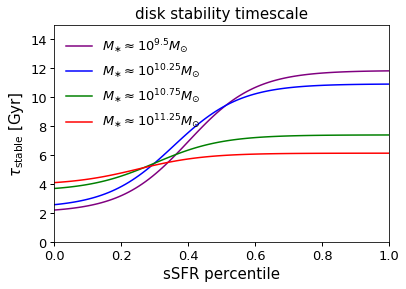

In [72]:
vmax_char = 200.
tau_low_vmax_q, tau_high_vmax_q = 2, 4
tau_low_vmax_sf, tau_high_vmax_sf = 12, 6
frac_q_low_vmax, frac_q_high_vmax = 0.35, 0.85

params = (vmax_char, tau_low_vmax_q, tau_high_vmax_q, 
          tau_low_vmax_sf, tau_high_vmax_sf, 
         frac_q_low_vmax, frac_q_high_vmax)

tau1 = stability_timescale(vmax_arr, dvmax_arr, *params)


fig, ax = plt.subplots(1, 1)

low_vmax_mask = vmax_arr==vmax_control_points[0]
lowmid_vmax_mask = vmax_arr==vmax_control_points[1]
mid_vmax_mask = vmax_arr==vmax_control_points[2]
high_vmax_mask = vmax_arr==vmax_control_points[3]
__=ax.plot(dvmax_arr[low_vmax_mask], tau1[low_vmax_mask], 
           color='purple', label=r'$M_{\ast} \approx 10^{9.5}M_{\odot}$')
__=ax.plot(dvmax_arr[lowmid_vmax_mask], tau1[lowmid_vmax_mask], 
           color='blue', label=r'$M_{\ast} \approx 10^{10.25}M_{\odot}$')
__=ax.plot(dvmax_arr[mid_vmax_mask], tau1[mid_vmax_mask], 
           color='green', label=r'$M_{\ast} \approx 10^{10.75}M_{\odot}$')
__=ax.plot(dvmax_arr[high_vmax_mask], tau1[high_vmax_mask], 
           color='red', label=r'$M_{\ast} \approx 10^{11.25}M_{\odot}$')

xlim = ax.set_xlim(0, 1)
ylim = ax.set_ylim(0, 15)
xlabel = ax.set_xlabel(r'sSFR percentile')
ylabel = ax.set_ylabel(r'$\tau_{\rm stable}$ $[{\rm Gyr}]$')
title = ax.set_title(r'disk stability timescale')
legend = ax.legend()

fig.savefig('disk_stability_vs_ssfr_percentile.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')
